In [13]:
import os
# If you get an issue with NVIDIA not supporting your version of gcc, set
# VERSION = whatever version you have on your computer that is supported
VERSION = 9
if VERSION is not None:
    os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
    os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
import numpy as np

from pathlib import Path
import os
import sys
sys.path.append(str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))
import torch
from gaussian_renderer import GaussianModel
from gaussian_renderer.eevr import splinerender
from scene.cameras import Camera, MiniCam
import matplotlib.pyplot as plt
from scene.dataset_readers import ProjectionType

/home/dronelab/gaussian-splatting-merge


In [15]:

sh_degree = 3
max_opacity = 0.99
gaussians = GaussianModel(sh_degree, max_opacity)
# on Google cloud, copy the file to a load directory, then read that path.
ply_path = ""
gaussians.load_ply(ply_path)

In [22]:
FoVx, FoVy, = 1.7084207766650255, 1.1578321073961255
R = np.array(
    [[-0.37808513, -0.02422472, -0.92545383],
     [-0.04448405,  0.99897826, -0.00797577],
     [ 0.92470147,  0.03815241, -0.37877644]])

T = np.array([-0.72235816,  0.21630537, -1.55684778])
image_height, image_width = 793, 1392
world_view_transform = torch.tensor([[-0.3781, -0.0242, -0.9255,  0.0000],
        [-0.0445,  0.9990, -0.0080,  0.0000],
        [ 0.9247,  0.0382, -0.3788,  0.0000],
        [-0.7224,  0.2163, -1.5568,  1.0000]])
full_proj_transform = torch.tensor([[-0.3293, -0.0371, -0.9255, -0.9255],
        [-0.0387,  1.5284, -0.0080, -0.0080],
        [ 0.8055,  0.0584, -0.3788, -0.3788],
        [-0.6292,  0.3309, -1.5670, -1.5568]])
refcam = MiniCam(image_width, image_height, FoVy, FoVx, 0, 1000, world_view_transform, full_proj_transform)
refcam.model = ProjectionType.PERSPECTIVE

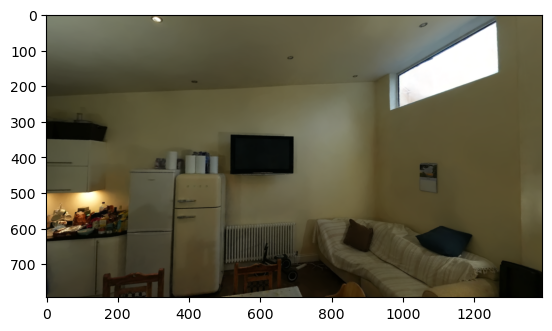

In [25]:

background = torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda")
# width = 1280
# height = 720
# width = 1200
# height = 667
width = refcam.image_width
height = refcam.image_height
image = torch.ones((3, height, width), dtype=float)
frames = []
with torch.no_grad():
    # rendering = renderer.render(view, pipeline, background)
    pipeline = lambda x: x
    pipeline.enable_GLO = False
    rendering = splinerender(refcam, gaussians, pipeline, background)["render"]
    byte_rendering = (rendering.permute(1, 2, 0).cpu().numpy()*255).clip(min=0, max=255).astype(np.uint8)
frames.append(byte_rendering)
# full_output_path = output_path / f"{i:06d}.png"
# imageio.imwrite(str(full_output_path), byte_rendering)
plt.imshow(byte_rendering)
plt.show()